In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import create_engine, inspect

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [8]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

In [9]:
# Using the inspector to print the column names within the 'measurement' table and its types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Using the inspector to print the column names within the 'measurement' table and its types
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

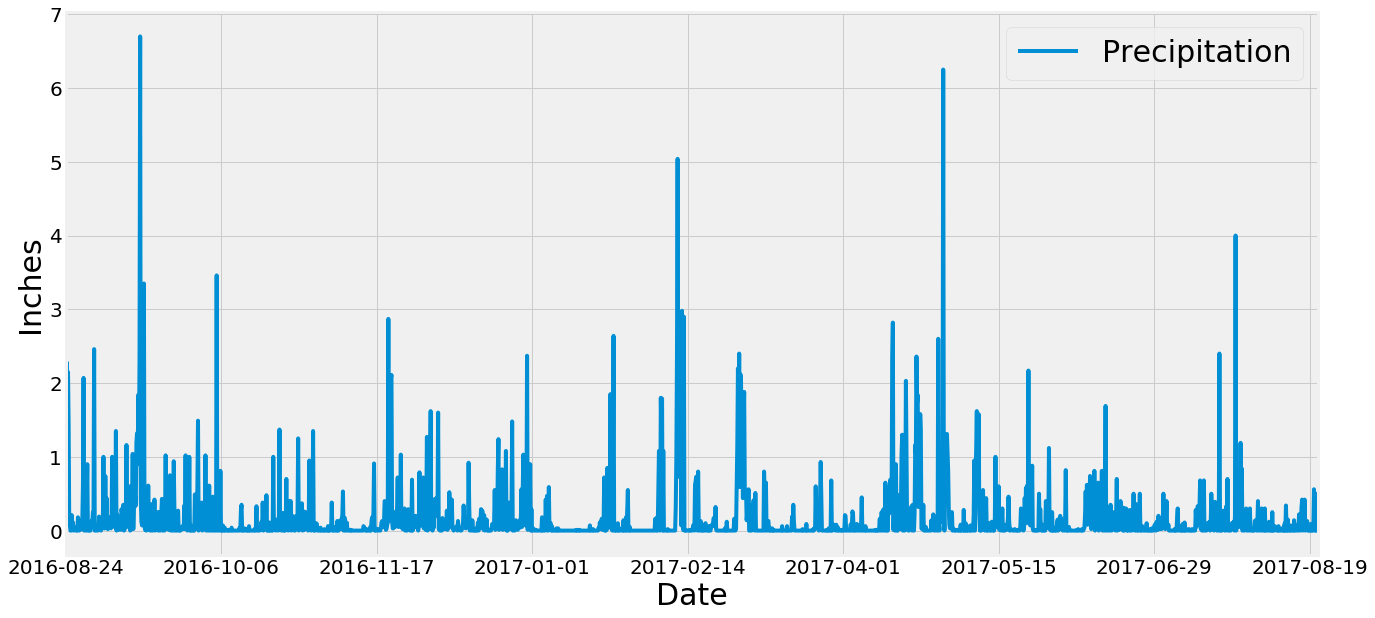

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
                            
# Query to find last date using "Measurement" class
last_date = (session.query(Measurement.date)\
             .order_by(Measurement.date.desc())\
             .first())

# Convert date string to datetime object keeping only YY-MM-DD
last_date = dt.datetime.strptime((list(np.ravel(last_date))[0]), '%Y-%m-%d').date()


# Calculate the date 1 year ago from the last data point in the database
prior_year_date = (last_date - dt.timedelta(days=365))

# Perform a query to retrieve the data and precipitation scores
precipitation_scores = (session.query(Measurement.date, Measurement.prcp)\
                  .filter(Measurement.date > prior_year_date)\
                  .order_by(Measurement.date)\
                  .all())

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation_scores)
precipitation_df = precipitation_df.set_index("date")

# Rename the "prcp" column and drop NaN values
precipitation_df.rename(columns = {"prcp":"Precipitation"}, inplace = True)
precipitation_df = precipitation_df.dropna(axis=0, how="any")

# Sort the dataframe by date
precipitation_df= precipitation_df.sort_index(ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(figsize=(20,10))
plt.xlabel("Date", size = 30)
plt.ylabel("Inches", size = 30)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.legend(prop={'size':30})
plt.savefig("Images/Precipitation.png")

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
number_of_stations = session.query(Station).count()
print(f"Number of Stations = {number_of_stations}")

Number of Stations = 9


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = (session.query(Measurement.station, func.count(Measurement.station))\
                        .group_by(Measurement.station)\
                        .order_by(func.count(Measurement.station).desc())\
                        .all())

print("Most Active Stations, Measurement Count")
active_stations

Most Active Stations, Measurement Count


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query identify the most active station and calculate:
# highest and lowest temperatures recorded, and average temperature
station_id = active_stations[0][0]
station_name = (session.query(Station.name).filter_by(station = station_id))

# Calculate the lowest temperature recorded,
lowest_temp = (session.query(Measurement.tobs)\
                     .filter(Measurement.station == station_id)\
                     .order_by(Measurement.tobs.asc())\
                     .first())

# Calculate the highest temperature recorded 
highest_temp = (session.query(Measurement.tobs)\
                     .filter(Measurement.station == station_id)\
                     .order_by(Measurement.tobs.desc())\
                     .first())

# Calculate the average temperature 
avg_temp = (session.query(func.avg(Measurement.tobs)).filter(Measurement.station == station_id))

print(f"The Most Active Station was: {station_name[0][0]}")
print(f"The Lowest Temperature was: {lowest_temp[0]}")
print(f"The Highest Temperature was: {highest_temp[0]}")
print(f"The Average Temperature was: {avg_temp[0][0]}")

The Most Active Station was: WAIHEE 837.5, HI US
The Lowest Temperature was: 54.0
The Highest Temperature was: 85.0
The Average Temperature was: 71.66378066378067


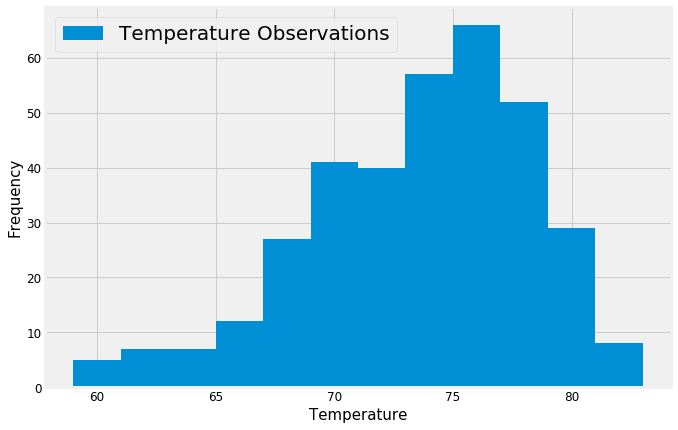

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = (session.query(Measurement.date, Measurement.tobs)\
                   .filter(Measurement.date > prior_year_date)\
                   .filter(Measurement.station == station_id)\
                   .order_by(Measurement.tobs.asc())\
                   .all())
# Convert to dataframe to use "bins" function
temp_data_df = pd.DataFrame(temp_data)

# Rename the "tobs" column and drop NaN values
temp_data_df.rename(columns = {"tobs":"Temperature Observations"}, inplace = True)
temp_data_df = temp_data_df.dropna(axis=0, how="any")

# Plot the results as a histogram
temp_data_df.plot(kind="hist", bins=12, figsize=(10,7))
plt.xlabel("Temperature", size = 15)
plt.ylabel("Frequency", size = 15)
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.legend(prop={'size':20})
plt.savefig("Images/Temperature.png")

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = prior_year_date
end_date = last_date
trip_temps = calc_temps(start_date, end_date)
min_temp = trip_temps[0][0]
avg_temp = trip_temps[0][1]
max_temp = trip_temps[0][2]

print("Trip Temperature Data:")
print(f"Start Date: {start_date}")
print(f"End Date: {end_date}")
print(f"Min Temp {min_temp}")
print(f"Avg Temp {avg_temp}")
print(f"Max Temp {max_temp}")

Trip Temperature Data:
Start Date: 2016-08-23
End Date: 2017-08-23
Min Temp 58.0
Avg Temp 74.59058295964125
Max Temp 87.0
